# How to analyze particle motion with MSD (Mean Square Displacement)

Note that this notebook is largely inspired from the excellent tutorials of Jean-Yves Tinevez available at https://tinevez.github.io/msdanalyzer/.

The goal of this notebook is mainly to help others (the author included) to analyze particle motion through MSD. I also would like to create a Python module that help dealing with all that kind of stuff.

TODO: I am still not sure the way I compute the MSD mean and also SEM and STD... I need to double check this.
TODO: I also need to find a way to improve MSD calculation : https://stackoverflow.com/questions/32988269/speedup-msd-calculation-in-python

In [1]:
# Some classic Python modules import
%matplotlib inline

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 10)

import pandas as pd
import numpy as np

from scipy import optimize

## Brownian motion

### Simulate particle motion

In [2]:
# Parameters
SPACE_UNITS = '\mu m'
TIME_UNITS = 's'

N_PARTICLES = 10
N_TIME_STEPS = 100
COORDS = ['x', 'y']
N_DIM = len(COORDS)

cm = plt.get_cmap('gist_rainbow')
COLORS = [cm(i/N_PARTICLES) for i in range(N_PARTICLES)]

# Typical values taken from studies of proteins diffusing in membranes:

# Diffusion coefficient
D  = 1e-3 # µm^2/s

# Time step between acquisition; fast acquisition!
dt = 0.05 # s

# Area size, just used to disperse particles in 2D. Has no impact on
# analysis
SIZE = 2 # µm

The Einstein equation tells us that displacements follow a Gaussian PDF with standard deviation given by :

In [3]:
k = np.sqrt(2 * D * dt)
print(k)

0.01


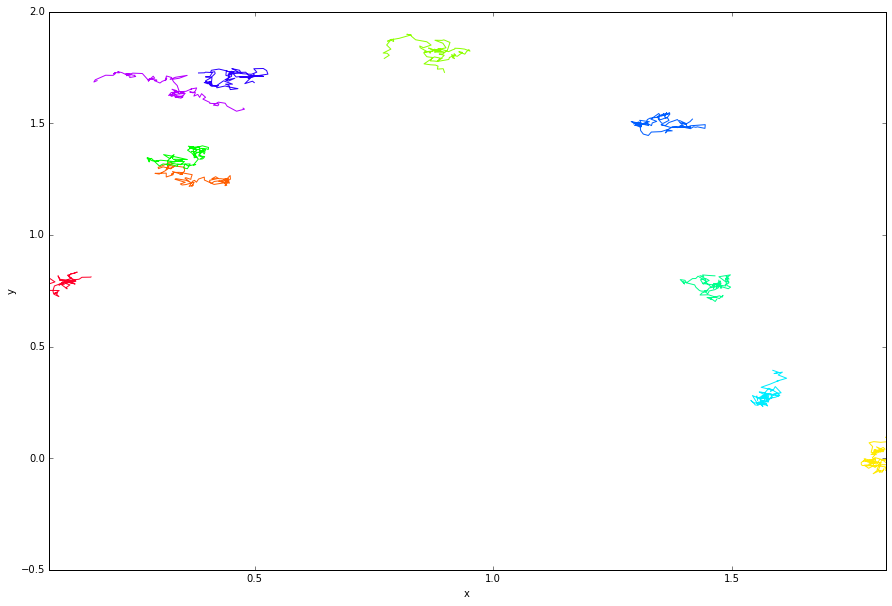

In [4]:
# Generate trajectories

trajs = []

for i in range(N_PARTICLES):
    
    # Generate time vector
    time = np.arange(0, N_TIME_STEPS) * dt

    # Get random displacement
    dp = k * np.random.randn(N_TIME_STEPS, N_DIM)

    # Setup custom initial position
    initial_position = SIZE * np.random.rand(1, N_DIM)
    dp[0] = initial_position

    # Get position
    p = np.cumsum(dp, axis=0)
    
    # Convert to Dataframe
    p = pd.DataFrame({c: p[:, i] for i, c in enumerate(COORDS)})
    p['t'] = time
    
    trajs.append(p)
    
# Plot trajectories
fig, ax = plt.subplots()

for color, traj in zip(COLORS, trajs):
    traj.plot(x='x', y='y', color=color, ax=ax, legend=False)
    
ax.set_xlabel(COORDS[0])
ax.set_ylabel(COORDS[1])

### MSD analysis

In [5]:
def compute_msd(trajectory, dt, coords=['x', 'y']):

    tau = trajectory['t'].copy()
    shifts = np.floor(tau / dt).astype(np.int)
    
    msds = pd.DataFrame()
    msds = np.zeros(shifts.size)
    msds_std = np.zeros(shifts.size)
    msds_sem = np.zeros(shifts.size)
    weights = np.zeros(shifts.size)

    for i, shift in enumerate(shifts):
        diffs = trajectory[coords] - trajectory[coords].shift(-shift)
        sqdist = np.square(diffs).sum(axis=1)
        msds[i] = sqdist.mean()
        msds_std[i] = sqdist.std()
        msds_sem[i] = sqdist.sem()
        weights[i] = len(sqdist.dropna())

    msds = pd.DataFrame({'msds': msds, 'tau': tau, 'msds_std': msds_std,
                         'msds_sem': msds_sem, 'weights': weights})
    return msds

def compute_msd_mean(trajs, dt, n_steps, coords=['x', 'y']):
    
    msd_mean = pd.DataFrame()
    msd_mean['tau'] = np.arange(0, n_steps) * dt
    msd_mean['msds'] = np.zeros(n_steps)
    msd_mean['msds_std'] = np.zeros(n_steps)
    msd_mean['msds_sem'] = np.zeros(n_steps)
    msd_mean['weights'] = np.zeros(n_steps)
        
    all_msd = []

    for i, traj in zip(range(len(trajs)), trajs):
        msds = compute_msd(traj, dt=dt, coords=coords)
        all_msd.append(msds)

        msd_mean['msds'] += msds['msds'] * msds['weights']
        msd_mean['msds_std'] += msds['msds_std'] * msds['weights']
        msd_mean['msds_sem'] += msds['msds_sem'] * msds['weights']
        
        msd_mean['weights'] += msds['weights']
        
    msd_mean['msds'] /= msd_mean['weights']
    msd_mean['msds_std'] /= msd_mean['weights']
    msd_mean['msds_sem'] /= msd_mean['weights']

    msd_mean.dropna(inplace=True)
    
    return msd_mean, all_msd

In [6]:
# Compute MSD
msd_mean, all_msd = compute_msd_mean(trajs, dt, N_TIME_STEPS, coords=COORDS)

In [7]:
# Fit model
def model(tau, D):
    return 2*D*N_DIM*tau

clip_factor = 0.25# Compute MSD
msd_mean, all_msd = compute_msd_mean(trajs, dt, N_TIME_STEPS, coords=COORDS)
t_stamp = np.round(len(msd_mean) * clip_factor, 0)
(D,), pcov = optimize.curve_fit(model, msd_mean.loc[:t_stamp, 'tau'], msd_mean.loc[:t_stamp, 'msds'])
print(D)

0.00088177799603


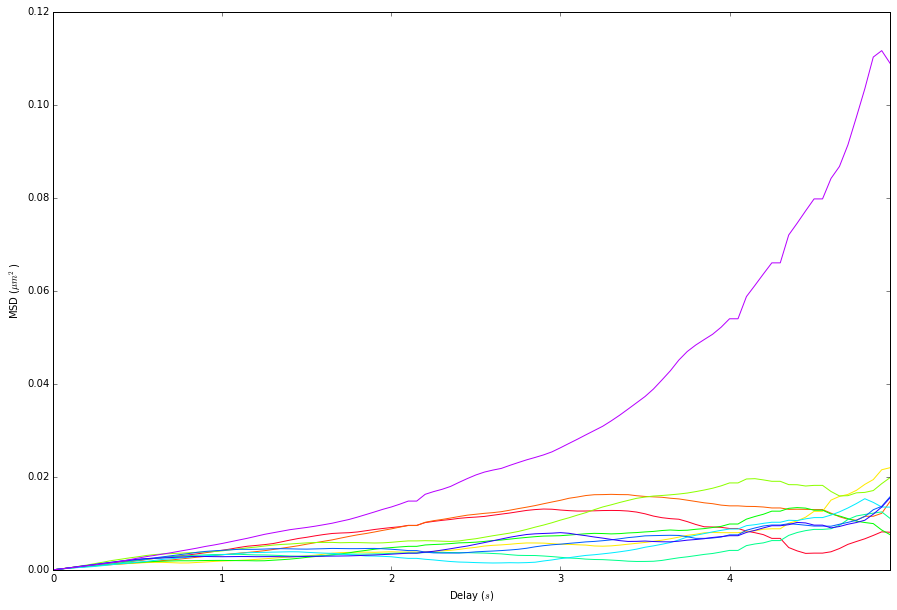

In [8]:
# Plot all MSD

fig, ax = plt.subplots()

for color, msd in zip(COLORS, all_msd):    
    msd.plot(x='tau', y='msds', color=color, ax=ax, legend=False)
    
ax.set_xlabel("Delay (${}$)".format(TIME_UNITS))
ax.set_ylabel("MSD (${}^2$)".format(SPACE_UNITS))

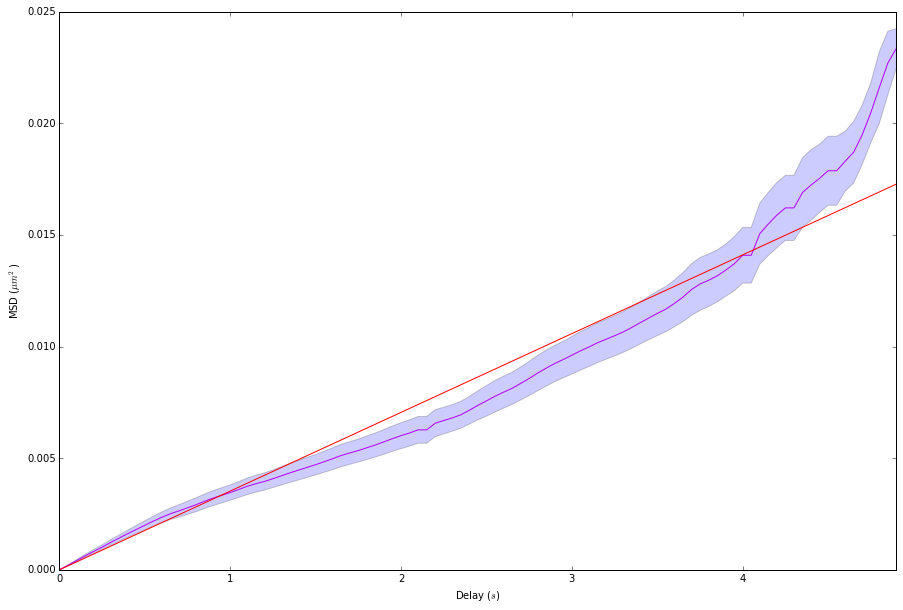

In [9]:
# Plot MSD mean

fig, ax = plt.subplots()

msd_mean.plot(x='tau', y='msds', color=color, ax=ax, legend=False)
ax.fill_between(msd_mean['tau'], msd_mean['msds'] - msd_mean['msds_sem'],
                msd_mean['msds'] + msd_mean['msds_sem'],  alpha=0.2)

ax.plot(msd_mean['tau'], model(msd_mean['tau'], D), color='red')

ax.set_xlabel("Delay (${}$)".format(TIME_UNITS))
ax.set_ylabel("MSD (${}^2$)".format(SPACE_UNITS))

## Directed motion

### Simulate particle motion

In [10]:
# Parameters
SPACE_UNITS = '\mu m'
TIME_UNITS = 's'

N_PARTICLES = 10
N_TIME_STEPS = 100
COORDS = ['x', 'y']
N_DIM = len(COORDS)

cm = plt.get_cmap('gist_rainbow')
COLORS = [cm(i/N_PARTICLES) for i in range(N_PARTICLES)]

# Typical values taken from studies of proteins diffusing in membranes:

# Diffusion coefficient
D  = 1e-3 # µm^2/s

# Time step between acquisition; fast acquisition!
dt = 0.05 # s

# Mean velocity
vm = 0.05 # µm/s

# Area size, just used to disperse particles in 2D. Has no impact on
# analysis
SIZE = 2 # µm

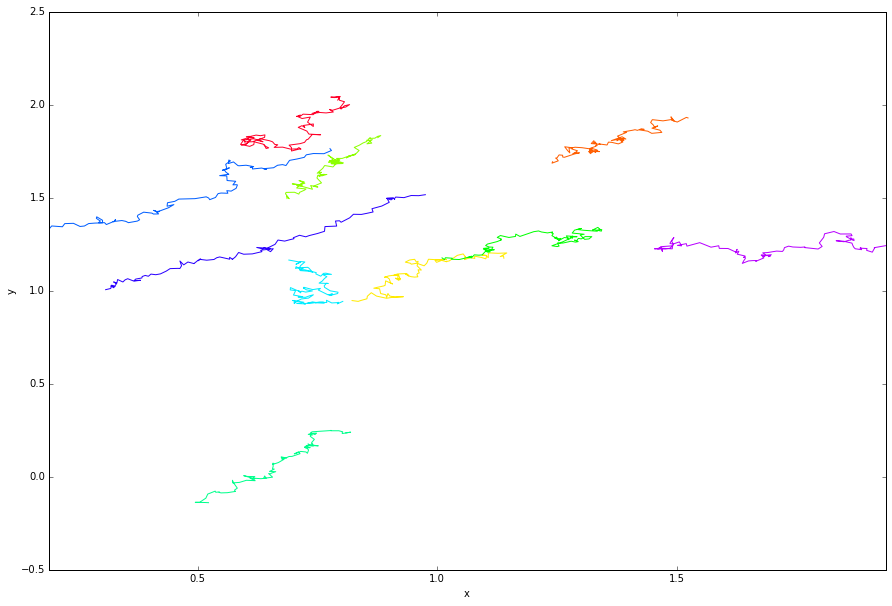

In [11]:
# Generate trajectories

trajs = []

for i in range(N_PARTICLES):
    
    # Generate time vector
    time = np.arange(0, N_TIME_STEPS) * dt
    
    # Velocity orientation
    theta = 2 * np.pi * np.random.rand()
    
    # Mean velocity
    v = vm * (1 + 1/4 * np.random.randn())

    # Get random displacement
    dp = k * np.random.randn(N_TIME_STEPS, N_DIM)
    
    dp_brownian = k * np.random.randn(N_TIME_STEPS, N_DIM)
    dp_directed = v * dt * (np.cos(theta) * np.ones((N_TIME_STEPS, 1)) + np.sin(theta) * np.ones((N_TIME_STEPS, 1)))
        
    dp = dp_brownian + dp_directed

    # Setup custom initial position
    initial_position = SIZE * np.random.rand(1, N_DIM)
    dp[0] = initial_position
    
    # Get position
    p = np.cumsum(dp, axis=0)
    
    # Convert to Dataframe
    p = pd.DataFrame({c: p[:, i] for i, c in enumerate(COORDS)})
    p['t'] = time
    
    trajs.append(p)
    
# Plot trajectories
fig, ax = plt.subplots()

for color, traj in zip(COLORS, trajs):
    traj.plot(x='x', y='y', color=color, ax=ax, legend=False)
    
ax.set_xlabel(COORDS[0])
ax.set_ylabel(COORDS[1])

### MSD analysis

In [12]:
# Compute MSD
msd_mean, all_msd = compute_msd_mean(trajs, dt, N_TIME_STEPS, coords=COORDS)

In [13]:
# Fit model
def model(tau, D, v):
    return 2*D*N_DIM*tau + v*tau**2

clip_factor = 1
t_stamp = np.round(len(msd_mean) * clip_factor, 0)
(D, v), pcov = optimize.curve_fit(model, msd_mean.loc[:t_stamp, 'tau'], msd_mean.loc[:t_stamp, 'msds'])
print(D)
print(v)

0.000484431092467
0.00907680681991


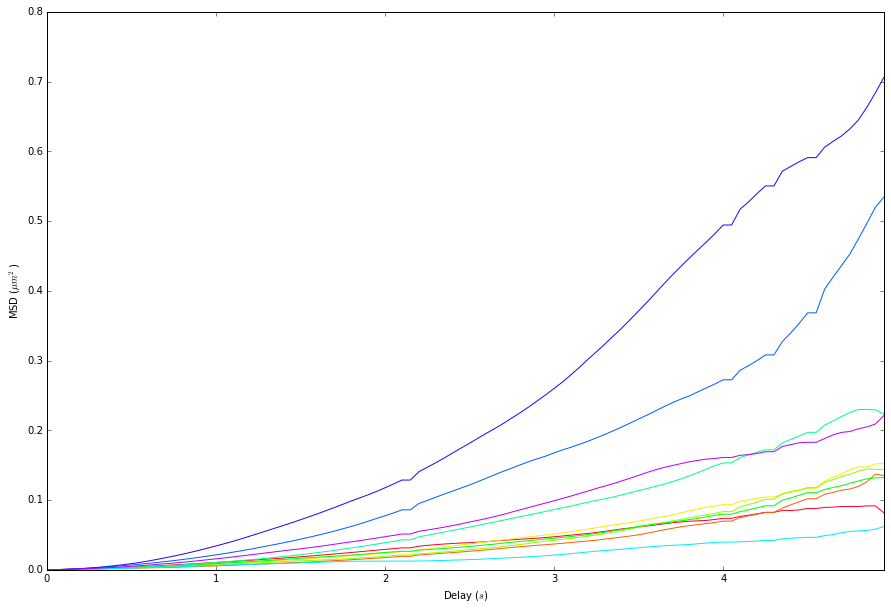

In [14]:
# Plot all MSD

fig, ax = plt.subplots()

for color, msd in zip(COLORS, all_msd):    
    msd.plot(x='tau', y='msds', color=color, ax=ax, legend=False)
    
ax.set_xlabel("Delay (${}$)".format(TIME_UNITS))
ax.set_ylabel("MSD (${}^2$)".format(SPACE_UNITS))

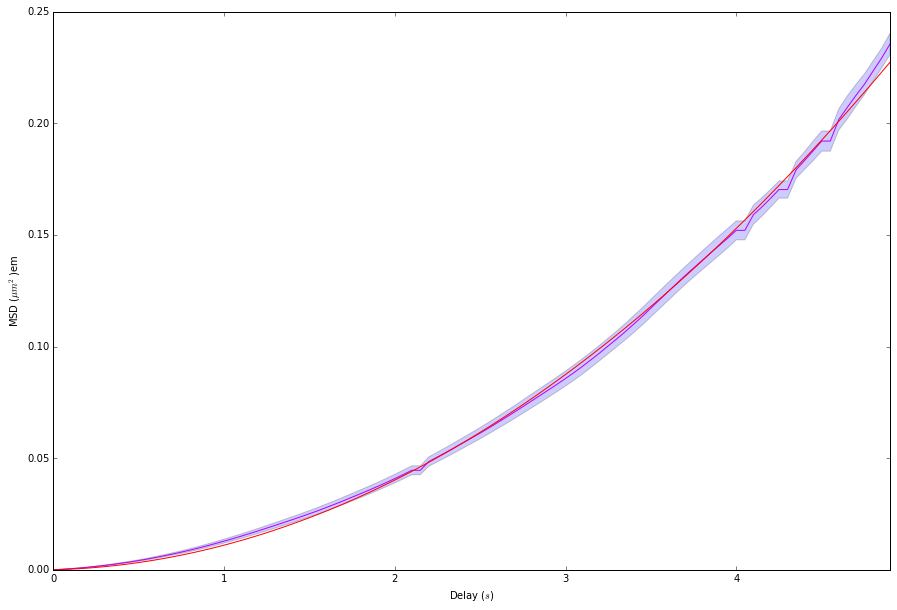

In [15]:
# Plot MSD mean

fig, ax = plt.subplots()

msd_mean.plot(x='tau', y='msds', color=color, ax=ax, legend=False)
ax.fill_between(msd_mean['tau'], msd_mean['msds'] - msd_mean['msds_sem'],
                msd_mean['msds'] + msd_mean['msds_sem'],  alpha=0.2)

ax.plot(msd_mean['tau'], model(msd_mean['tau'], D, v), color='red')

ax.set_xlabel("Delay (${}$)".format(TIME_UNITS))
ax.set_ylabel("MSD (${}^2$)em".format(SPACE_UNITS))

## Confined motion (more work is needed here)

### Simulate particle motion

In [16]:
# Parameters
SPACE_UNITS = '\mu m'
TIME_UNITS = 's'

N_PARTICLES = 10
N_TIME_STEPS = 200
COORDS = ['x', 'y']
N_DIM = len(COORDS)

cm = plt.get_cmap('gist_rainbow')
COLORS = [cm(i/N_PARTICLES) for i in range(N_PARTICLES)]

# Typical values taken from studies of proteins diffusing in membranes:

# Diffusion coefficient
D  = 1e-3 # µm^2/s

# Time step between acquisition; fast acquisition!
dt = 0.05 # s

# Boltzman constant
kt = 4.2821e-21 # kBoltzman x T @ 37ºC

# Area size, just used to disperse particles in 2D. Has no impact on
# analysis
SIZE = 5 # µm

k = np.sqrt(2 * D * dt)

# Confined motion parameters

# Particle in a potential: settings the 'stiffness' of the energy potential
# Typical diameter of the trap (still in micron)
ltrap = 0.05 # µm
ktrap = kt / ltrap**2 # = thermal energy / trap size ^ 2

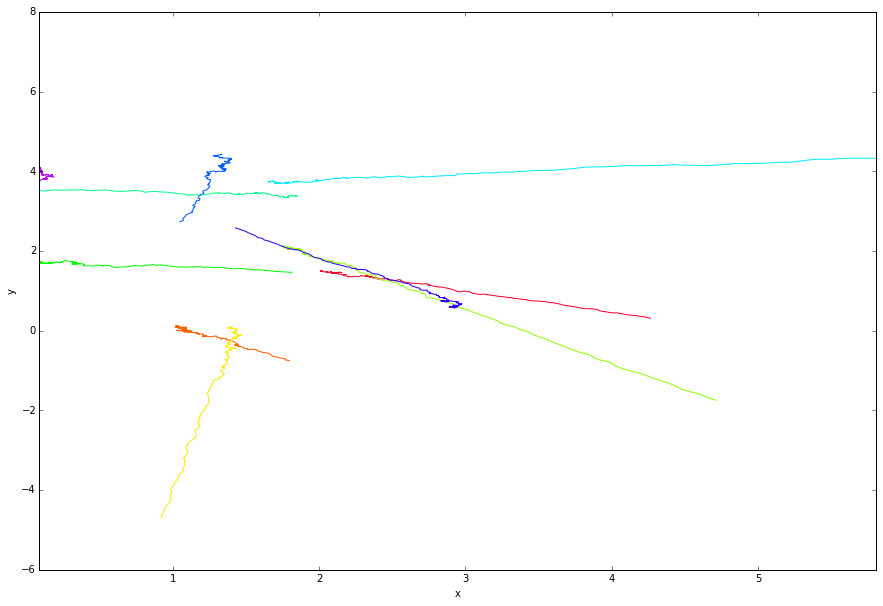

In [17]:
# Generate trajectories

def Fx(x, initial_position):
    return ktrap * (x - initial_position)

trajs = []

for i in range(N_PARTICLES):
    
    # Generate time vector
    time = np.arange(0, N_TIME_STEPS) * dt
    
    # Energy potential:
    #V = @(x) 0.5 * ktrap * sum (x .^ 2) # Unused, just to show

    p = np.zeros((N_TIME_STEPS, N_DIM))

    # Setup custom initial position
    initial_position = SIZE * np.random.rand(1, N_DIM)
    p[0] = initial_position

    for j in range(1, N_TIME_STEPS):
        dxtrap = D / kt * Fx(p[j-1], initial_position) * dt # ad hoc displacement
        dxbrownian = k * np.random.randn(1, N_DIM);

        p[j] = p[j-1] + dxtrap + dxbrownian
    
    # Convert to Dataframe
    p = pd.DataFrame({c: p[:, i] for i, c in enumerate(COORDS)})
    p['t'] = time
    
    trajs.append(p)
    
# Plot trajectories
fig, ax = plt.subplots()

for color, traj in zip(COLORS, trajs):
    traj.plot(x='x', y='y', color=color, ax=ax, legend=False)
    
ax.set_xlabel(COORDS[0])
ax.set_ylabel(COORDS[1])

### MSD analysis

In [18]:
# Compute MSD
msd_mean, all_msd = compute_msd_mean(trajs, dt, N_TIME_STEPS, coords=COORDS)

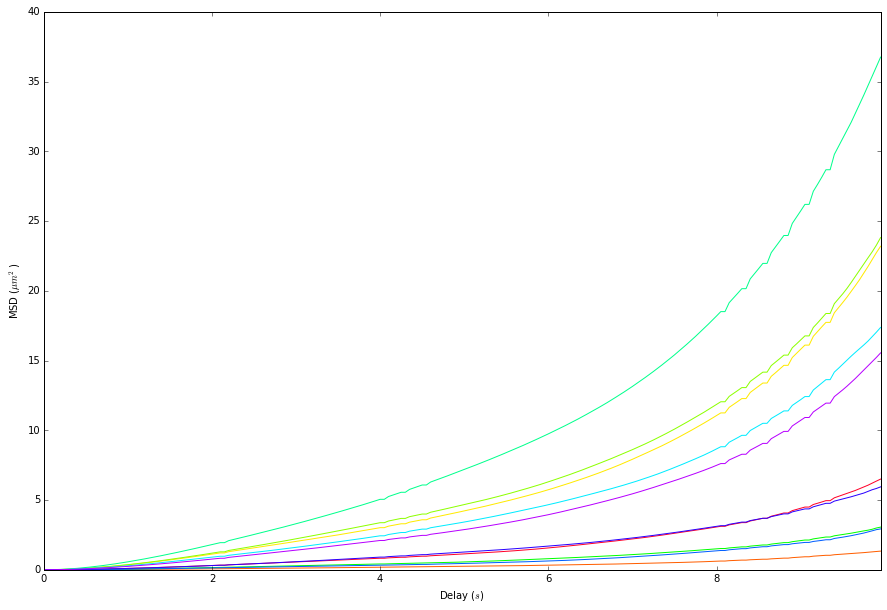

In [19]:
# Plot all MSD

fig, ax = plt.subplots()

for color, msd in zip(COLORS, all_msd):    
    msd.plot(x='tau', y='msds', color=color, ax=ax, legend=False)
    
ax.set_xlabel("Delay (${}$)".format(TIME_UNITS))
ax.set_ylabel("MSD (${}^2$)".format(SPACE_UNITS))